In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
% cd "/content/drive/Shareddrives/MIRCV Project/index/"

/content/drive/Shareddrives/MIRCV Project/index


In [ ]:
# run IVFADC index notebook
% run index_IVFADC.ipynb

In [ ]:
# this jupyter extension will print out the running time of cell executions
!pip install -q ipython-autotime
%load_ext autotime

time: 203 µs (started: 2022-04-14 20:51:26 +00:00)


In [ ]:
!pip install -q faiss-cpu

     |████████████████████████████████| 8.6 MB 5.5 MB/s 
time: 4.56 s (started: 2022-04-14 20:51:26 +00:00)


# Approximate Nearest Neighbors Search with quantization

##Import needed packages

In [ ]:
import math
import time
import faiss
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import pickle

time: 210 ms (started: 2022-04-14 20:51:37 +00:00)


#Test

In [ ]:
# compute true neigbours
def compute_true_neighbors(query, all_features, n_neighbors):
  start_time = time.time()
  distances_matrix = cdist(query, all_features, metric='sqeuclidean') # compute multidimensional distances
  true_neighbors = distances_matrix.argsort(axis=1)[:,:n_neighbors]
  distances_matrix = distances_matrix[np.arange(query.shape[0]).reshape(-1, 1), true_neighbors]
  scan_time = time.time() - start_time
  return true_neighbors, distances_matrix, scan_time

time: 13.7 ms (started: 2022-04-14 20:51:40 +00:00)


In [ ]:
# helper functions to show pretty units in matplotlib plots
from matplotlib.ticker import FuncFormatter

def format_time(x, pos):
  h, x = x // 3600, x % 3600
  m, s = x // 60, x % 60
  hh = f'{h:.0f}h' if h else ''
  mm = f'{m:.0f}m' if m else ''
  ss = f'{s:.0f}s' if s or not (h or m) else ''
  return hh + mm + ss

def format_size(x, pos):
  return f'{(x / 1e6):.0f}MB'

megabyte_formatter = FuncFormatter(format_size)  # show index_size in MB
time_formatter = FuncFormatter(format_time)  # show time in hms

time: 36.8 ms (started: 2022-04-14 20:51:41 +00:00)


###Experiment 1 - 512 extracted features, no Distractors

In [ ]:
path = "/content/drive/Shareddrives/MIRCV Project/Performance Evaluation/features_train_512_FT.pkl"

features_512= np.load(path, allow_pickle=True)
features_512.shape

(20580, 512)

time: 210 ms (started: 2022-04-14 17:55:25 +00:00)


In [ ]:
#normalize 
features_512 = normalize(features_512)

time: 85.4 ms (started: 2022-04-14 17:55:25 +00:00)


In [ ]:
n, d = features_512.shape
n_queries = 100
k = 100

# select random query from the dataset
query_index = np.random.choice(n, n_queries, replace=False)
query = features_512[query_index]
query.shape

(100, 512)

time: 13.4 ms (started: 2022-04-14 17:55:25 +00:00)


In [ ]:
true_neighbors, true_distances, _ = compute_true_neighbors(query, features_512, k)
true_neighbors, true_distances

(array([[ 4312, 14585,  4449, ...,  2363,  2479, 18647],
        [18926, 18865, 18876, ..., 18918,  9529,  9651],
        [16327, 16292, 16297, ...,  8158,  8083, 16316],
        ...,
        [10021, 10042, 10164, ..., 10139, 10143, 10043],
        [10564, 10516, 10445, ..., 10430, 10550, 13137],
        [ 7744,  7762,  7697, ...,  7819,  7847,  7856]]),
 array([[0.        , 0.43819761, 0.44893212, ..., 0.61785647, 0.61867493,
         0.61970708],
        [0.        , 0.17747119, 0.18629954, ..., 0.39348051, 0.39410431,
         0.39504186],
        [0.        , 0.27641727, 0.28026418, ..., 0.48641357, 0.4888488 ,
         0.4894457 ],
        ...,
        [0.        , 0.40124089, 0.40124089, ..., 0.66794242, 0.67051251,
         0.67145797],
        [0.        , 0.23135136, 0.25789089, ..., 0.55380665, 0.55439261,
         0.55814496],
        [0.        , 0.25280951, 0.25603308, ..., 0.38941119, 0.38949275,
         0.39331196]]))

time: 2.22 s (started: 2022-04-14 17:55:25 +00:00)


In [ ]:
nlists = [20, 25, 30]
nprobes = [2**i for i in range(8)]
n_subvecs = (64, 128, 256)
n_bits = 8
k = 100

results = []
for nlist in tqdm(nlists):
  for n_subvec in tqdm(n_subvecs, leave=False):

    # build the index
    inverted_list = KmeansCoarseQuantizer(d, nlist)
    index = IVFADC(inverted_list, d, n_subvec, n_bits)
    index.train(features_512, 5_000)

    for nprobe in nprobes:
      if nprobe > nlist:
        break

      I, D, search_time = index.search(query, k, nprobe, 'sqeuclidean')

      # compute the recall
      recall = index.compute_recall(true_neighbors, I)  

      # collect parameters and results
      results.append({
          'nlist': nlist,
          'n_subvec': n_subvec,
          'n_bits': n_bits,
          'nprobe': nprobe,
          'recall': recall,
          'search_time': search_time,
          'train_time': index.get_train_time()
      })

results = pd.DataFrame(results)
results.to_csv("/content/drive/Shareddrives/MIRCV Project/index/TestResults/results_512.csv", index=False)
results

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


,nlist,n_subvec,n_bits,nprobe,recall,search_time,train_time
0,20,64,8,1,0.8387,0.456018,39.957294
1,20,64,8,2,0.9117,1.159287,39.957294
2,20,64,8,4,0.9455,1.783418,39.957294
3,20,64,8,8,0.9507,3.286710,39.957294
4,20,64,8,16,0.9515,6.500959,39.957294
5,20,128,8,1,0.8194,0.711155,44.883340
6,20,128,8,2,0.9323,1.429492,44.883340
7,20,128,8,4,0.9632,2.881603,44.883340
8,20,128,8,8,0.9742,5.749427,44.883340
9,20,128,8,16,0.9753,11.338649,44.883340


time: 10min 59s (started: 2022-04-14 17:55:27 +00:00)


In [ ]:
# compute the average query time
results['query_time'] = results['search_time'] / 100

# compute index size (including codebook)
results['index_size'] = \
  len(features_512) * results['n_subvec'] * (results['n_bits'] / 8) \
  + (d * 4 * results['nlist']) \
  + (d * 4 * 2 ** results['n_bits'])

time: 10.9 ms (started: 2022-04-14 18:06:27 +00:00)


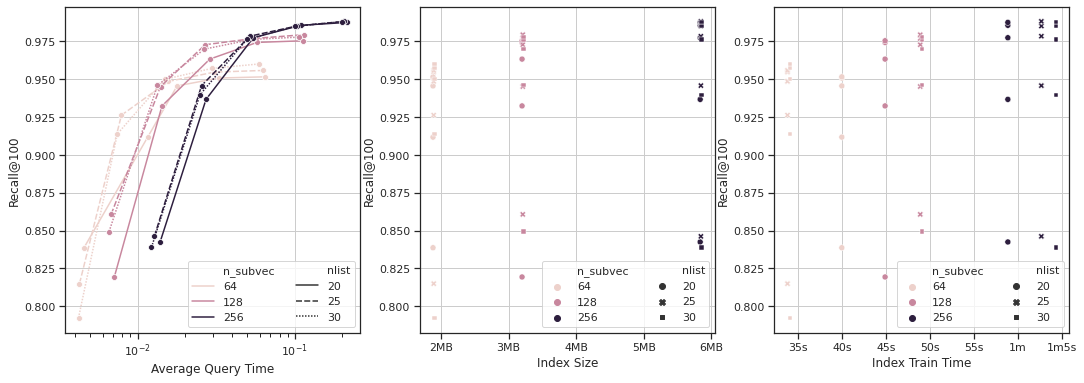

time: 1.21 s (started: 2022-04-14 18:06:27 +00:00)


In [ ]:
sns.set_theme(style='ticks')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# recall vs search_time
sns.lineplot(data=results, x='query_time', y='recall', hue='n_subvec', style='nlist', marker='o', ax=ax1)
ax1.set_xlabel('Average Query Time')
ax1.set_ylabel('Recall@100')
ax1.legend(ncol=2)
ax1.set_xscale('log')
ax1.grid()

# recall vs index_size
sns.scatterplot(data=results, x='index_size', y='recall', hue='n_subvec', style='nlist', ax=ax2)
ax2.set_xlabel('Index Size')
ax2.set_ylabel('Recall@100')
ax2.legend(ncol=2)
ax2.xaxis.set_major_formatter(megabyte_formatter)
ax2.grid()

# recall vs train_time
sns.scatterplot(data=results, x='train_time', y='recall', hue='n_subvec', style='nlist', ax=ax3)
ax3.set_xlabel('Index Train Time')
ax3.set_ylabel('Recall@100')
ax3.legend(ncol=2)
ax3.xaxis.set_major_formatter(time_formatter)
ax3.grid()

###Experiment 2 - 512 extracted features + Distractors

In [ ]:
#path_features_distractors = "/content/drive/Shareddrives/MIRCV Project/others/features/features_512_distractors.npy"
#path_features_images = "/content/drive/Shareddrives/MIRCV Project/others/features/features_512.npy"

#features_images = np.load(path_features_images)
#features_distractors = np.load(path_features_distractors)

#features_512_distractors = np.concatenate((features_images, features_distractors))

path = '/content/drive/Shareddrives/MIRCV Project/Performance Evaluation/features_train_dis_512_FT.pkl'
features_512_distractors = np.load(path, allow_pickle=True)
features_512_distractors.shape

(45580, 512)

time: 5.01 s (started: 2022-04-14 18:06:28 +00:00)


In [ ]:
#normalize 
features_512_distractors = normalize(features_512_distractors)

time: 76.2 ms (started: 2022-04-14 18:06:33 +00:00)


In [ ]:
n, d = features_512_distractors.shape
n_queries = 100
k = 100

# select random query from the dataset
query_index = np.random.choice(n, n_queries, replace=False)
query = features_512_distractors[query_index]
query.shape

(100, 512)

time: 11.1 ms (started: 2022-04-14 18:06:33 +00:00)


In [ ]:
true_neighbors, true_distances, _ = compute_true_neighbors(query, features_512_distractors, k)
true_neighbors, true_distances

(array([[30386, 34105, 30513, ..., 27010, 35411, 34310],
        [34283, 35093, 33164, ..., 29000, 38448, 21910],
        [ 8015,  8050,  7908, ...,  7971,  7976,  7900],
        ...,
        [42714, 27695, 26356, ..., 30010, 38291, 23287],
        [25360, 41588, 37268, ..., 23535, 40055, 23052],
        [ 8354,  8740,  8704, ...,  8382,  8399,  8411]]),
 array([[0.        , 0.55456677, 0.55818941, ..., 0.80884341, 0.80894154,
         0.80962072],
        [0.        , 0.34439611, 0.40125721, ..., 0.61625806, 0.61653565,
         0.61726906],
        [0.        , 0.09458095, 0.10414809, ..., 0.37083011, 0.37105457,
         0.37845949],
        ...,
        [0.        , 0.45194601, 0.49405804, ..., 0.61026455, 0.61056824,
         0.61056872],
        [0.        , 0.37386676, 0.38904127, ..., 0.55772217, 0.5584512 ,
         0.55873368],
        [0.        , 0.24864012, 0.25378571, ..., 0.40226278, 0.402797  ,
         0.40345307]]))

time: 2.91 s (started: 2022-04-14 18:06:33 +00:00)


In [ ]:
nlists = [25, 35, 45]
nprobes = [2**i for i in range(8)]
n_subvecs = (64, 128, 256)
n_bits = 8
k = 100

results = []
for nlist in tqdm(nlists):
  for n_subvec in tqdm(n_subvecs, leave=False):

    # build the index
    inverted_list = KmeansCoarseQuantizer(d, nlist)
    index = IVFADC(inverted_list, d, n_subvec, n_bits)
    index.train(features_512_distractors, 5_000)

    for nprobe in nprobes:
      if nprobe > nlist:
        break

      I, D, search_time = index.search(query, k, nprobe, 'sqeuclidean')

      # compute the recall
      recall = index.compute_recall(true_neighbors, I)  

      # collect parameters and results
      results.append({
          'nlist': nlist,
          'n_subvec': n_subvec,
          'n_bits': n_bits,
          'nprobe': nprobe,
          'recall': recall,
          'search_time': search_time,
          'train_time': index.get_train_time()
      })

results = pd.DataFrame(results)
results.to_csv("/content/drive/Shareddrives/MIRCV Project/index/TestResults/results_512_distractors.csv", index=False)
results

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


,nlist,n_subvec,n_bits,nprobe,recall,search_time,train_time
0,25,64,8,1,0.7321,0.599360,60.094507
1,25,64,8,2,0.8492,1.117403,60.094507
2,25,64,8,4,0.8905,2.319218,60.094507
3,25,64,8,8,0.9011,4.531334,60.094507
4,25,64,8,16,0.9018,8.118372,60.094507
5,25,128,8,1,0.7551,1.005875,95.986952
6,25,128,8,2,0.8852,2.093475,95.986952
7,25,128,8,4,0.9377,4.160621,95.986952
8,25,128,8,8,0.9492,8.186411,95.986952
9,25,128,8,16,0.9503,14.480224,95.986952


time: 21min 52s (started: 2022-04-14 18:06:36 +00:00)


In [ ]:
# compute the average query time
results['query_time'] = results['search_time'] / 100

# compute index size (including codebook)
results['index_size'] = \
  len(features_512_distractors) * results['n_subvec'] * (results['n_bits'] / 8) \
  + (d * 4 * results['nlist']) \
  + (d * 4 * 2 ** results['n_bits'])

time: 7.21 ms (started: 2022-04-14 18:28:28 +00:00)


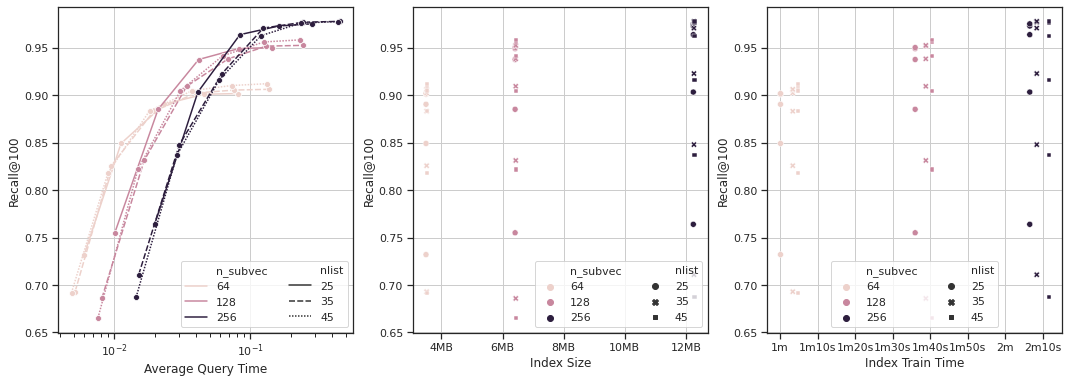

time: 1.17 s (started: 2022-04-14 18:28:28 +00:00)


In [ ]:
sns.set_theme(style='ticks')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# recall vs search_time
sns.lineplot(data=results, x='query_time', y='recall', hue='n_subvec', style='nlist', marker='o', ax=ax1)
ax1.set_xlabel('Average Query Time')
ax1.set_ylabel('Recall@100')
ax1.legend(ncol=2)
ax1.set_xscale('log')
ax1.grid()

# recall vs index_size
sns.scatterplot(data=results, x='index_size', y='recall', hue='n_subvec', style='nlist', ax=ax2)
ax2.set_xlabel('Index Size')
ax2.set_ylabel('Recall@100')
ax2.legend(ncol=2)
ax2.xaxis.set_major_formatter(megabyte_formatter)
ax2.grid()

# recall vs train_time
sns.scatterplot(data=results, x='train_time', y='recall', hue='n_subvec', style='nlist', ax=ax3)
ax3.set_xlabel('Index Train Time')
ax3.set_ylabel('Recall@100')
ax3.legend(ncol=2)
ax3.xaxis.set_major_formatter(time_formatter)
ax3.grid()

###Experiment 3 - Index Vs Brute force, no Distractors

In [ ]:
def euclidian_distance(y1, y2):
    return np.sqrt(np.sum((y1-y2)**2))

def brute_force_search(query, features, n_neighbors):
  start = time.time()
  dist_array = np.zeros(len(features))
  for i, feature in enumerate(features):
    dist_array[i] = euclidian_distance(query, feature)

  true_neighbors = dist_array.argsort()[:n_neighbors]
  dist_array = dist_array[true_neighbors]
  
  scan_time = time.time() - start

  return np.array(true_neighbors), np.array(dist_array), scan_time

time: 25.8 ms (started: 2022-04-14 20:54:22 +00:00)


In [ ]:
path = "/content/drive/Shareddrives/MIRCV Project/Performance Evaluation/features_train_512_FT.pkl"

features_512= np.load(path, allow_pickle=True)
features_512.shape

(20580, 512)

time: 619 ms (started: 2022-04-14 20:54:25 +00:00)


In [ ]:
#normalize 
features_512 = normalize(features_512)

time: 42.7 ms (started: 2022-04-14 20:54:27 +00:00)


In [ ]:
n, d = features_512.shape
n_queries = 50

# select random query from the dataset
query_index = np.random.choice(n, n_queries, replace=False)
query = features_512[query_index]
current_features = np.delete(features_512, query_index, axis=0)
n, d = current_features.shape

current_features.shape, query.shape

((20530, 512), (50, 512))

time: 36.4 ms (started: 2022-04-14 20:54:29 +00:00)


In [ ]:
n_list = 35
n_subvec = 256
n_bits = 8

# build the index
inverted_list = KmeansCoarseQuantizer(d, n_list)
index = IVFADC(inverted_list, d, n_subvec, n_bits)
index.train(current_features, 5_000)

/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


time: 1min 5s (started: 2022-04-14 20:57:51 +00:00)


In [ ]:
k = 100
n_probe = 4
results = []
for q in query:
  q = q.reshape(1, -1)

  # Brute force search
  I_bf, D_bf, scan_time_br = brute_force_search(q, current_features, k)

  # optimized brute force
  I_obf, D_obf, scan_time_obr = compute_true_neighbors(q, current_features, k)

  # approximate search
  I_ivfadc, D_ivfadc, search_time_ivfadc = index.search(q, k, n_probe, "sqeuclidean")

  result = {
      "bf_time": scan_time_br,
      "obf_time": scan_time_obr,
      "ivfadc_time": search_time_ivfadc,
      "recall": index.compute_recall(I_obf, I_ivfadc)
  }
  results.append(result)

results = pd.DataFrame(results)
results

,bf_time,obf_time,ivfadc_time,recall
0,0.252716,0.027244,0.051608,0.83
1,0.250934,0.025042,0.053536,0.98
2,0.250087,0.027621,0.052481,0.85
3,0.248142,0.025259,0.060280,0.96
4,0.256298,0.025432,0.051273,0.99
5,0.249106,0.024933,0.047935,0.97
6,0.244843,0.024842,0.047683,1.00
7,0.256127,0.024948,0.048770,0.99
8,0.250270,0.024874,0.050401,1.00
9,0.270611,0.025693,0.047540,0.99


time: 16.2 s (started: 2022-04-14 21:01:14 +00:00)


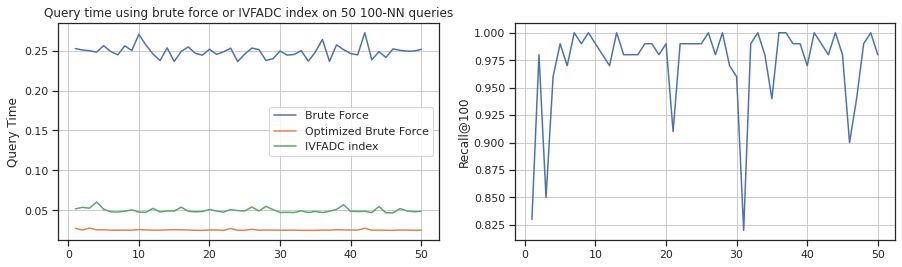

time: 504 ms (started: 2022-04-14 21:01:38 +00:00)


In [ ]:
sns.set_theme(style='ticks')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

x_q = np.array(range(1,n_queries+1))

# recall vs search_time
sns.lineplot(data=results, x=x_q, y='bf_time', ax=ax1)
sns.lineplot(data=results, x=x_q, y='obf_time', ax=ax1)
sns.lineplot(data=results, x=x_q, y='ivfadc_time', ax=ax1)

ax1.title.set_text(f"Query time using brute force or IVFADC index on {n_queries} {k}-NN queries")
ax1.set_xlabel('')
ax1.set_ylabel('Query Time')
ax1.legend(["Brute Force", "Optimized Brute Force","IVFADC index"])
ax1.grid()

sns.lineplot(data=results, x=x_q, y='recall', ax=ax2, legend=False)
ax2.set_ylabel('Recall@100')
ax2.grid()

In [ ]:
results_mean = results.mean()

print(f"Mean query time Brute Force: {results_mean['bf_time']:.2f}")
print(f"Mean query time Optimized Brute Force: {results_mean['obf_time']:.2f}")
print(f"Mean query time IVFADC index: {results_mean['ivfadc_time']:.2f}")

print(f"Mean recall: {results_mean['recall']:.2f}")

Mean query time Brute Force: 0.25
Mean query time Optimized Brute Force: 0.03
Mean query time IVFADC index: 0.05
Mean recall: 0.97
time: 4.74 ms (started: 2022-04-14 21:02:03 +00:00)


###Experiment 4 - Index Vs Brute force + Distractors

In [ ]:
def euclidian_distance(y1, y2):
    return np.sqrt(np.sum((y1-y2)**2))

def brute_force_search(query, features, n_neighbors):
  start = time.time()
  dist_array = np.zeros(len(features))
  for i, feature in enumerate(features):
    dist_array[i] = euclidian_distance(query, feature)

  true_neighbors = dist_array.argsort()[:n_neighbors]
  dist_array = dist_array[true_neighbors]
  
  scan_time = time.time() - start

  return np.array(true_neighbors), np.array(dist_array), scan_time

time: 6.97 ms (started: 2022-04-14 21:02:45 +00:00)


In [ ]:
#path_features_distractors = "/content/drive/Shareddrives/MIRCV Project/others/features/features_512_distractors.npy"
#path_features_images = "/content/drive/Shareddrives/MIRCV Project/others/features/features_512.npy"

#features_images = np.load(path_features_images)
#features_distractors = np.load(path_features_distractors)

#features_512_distractors = np.concatenate((features_images, features_distractors))

path = '/content/drive/Shareddrives/MIRCV Project/Performance Evaluation/features_train_dis_512_FT.pkl'
features_512_distractors = np.load(path, allow_pickle=True)
features_512_distractors.shape

(45580, 512)

time: 1.32 s (started: 2022-04-14 21:02:46 +00:00)


In [ ]:
#normalize 
features_512_distractors = normalize(features_512_distractors)

time: 77.9 ms (started: 2022-04-14 21:02:47 +00:00)


In [ ]:
n, d = features_512_distractors.shape
n_queries = 50

# select random query from the dataset
query_index = np.random.choice(n, n_queries, replace=False)
query = features_512_distractors[query_index]
current_features = np.delete(features_512_distractors, query_index, axis=0)
n, d = current_features.shape

current_features.shape, query.shape

((45530, 512), (50, 512))

time: 43 ms (started: 2022-04-14 21:02:47 +00:00)


In [ ]:
n_list = 45
n_probe = 4
n_subvec = 256
n_bits = 8

# build the index
inverted_list = KmeansCoarseQuantizer(d, n_list)
index = IVFADC(inverted_list, d, n_subvec, n_bits)
index.train(current_features, 5_000)

/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


time: 2min 11s (started: 2022-04-14 21:04:25 +00:00)


In [ ]:
n_probe = 4
k = 100
n_probe = 10
results = []
for q in query:
  q = q.reshape(1, -1)

  # Brute force search
  I_bf, D_bf, scan_time_br = brute_force_search(q, current_features, k)

  # optimized brute force
  I_obf, D_obf, scan_time_obr = compute_true_neighbors(q, current_features, k)

  # approximate search
  I_ivfadc, D_ivfadc, search_time_ivfadc = index.search(q, k, n_probe, "sqeuclidean")

  result = {
      "bf_time": scan_time_br,
      "obf_time": scan_time_obr,
      "ivfadc_time": search_time_ivfadc,
      "recall": index.compute_recall(I_obf, I_ivfadc)
  }
  results.append(result)

results = pd.DataFrame(results)
results

,bf_time,obf_time,ivfadc_time,recall
0,0.601208,0.057011,0.176129,0.98
1,0.582544,0.057715,0.160508,0.97
2,0.554324,0.057756,0.154931,0.95
3,0.553229,0.055761,0.158485,0.99
4,0.553363,0.057144,0.149854,0.98
5,0.576726,0.056551,0.140791,0.99
6,0.564106,0.055721,0.149886,0.99
7,0.545744,0.056819,0.156466,0.91
8,0.554062,0.058315,0.149015,0.99
9,0.555193,0.055135,0.159102,0.95


time: 38.3 s (started: 2022-04-14 21:09:58 +00:00)


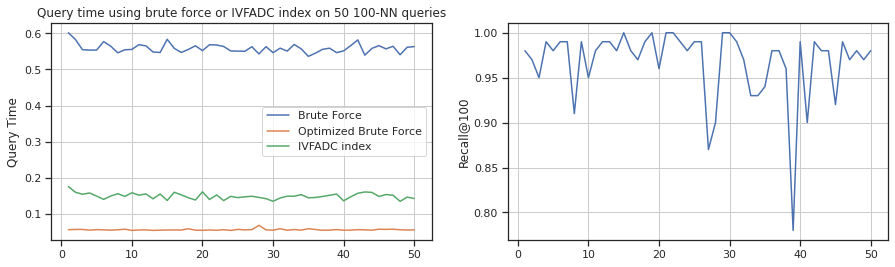

time: 472 ms (started: 2022-04-14 21:11:07 +00:00)


In [ ]:
sns.set_theme(style='ticks')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

x_q = np.array(range(1,n_queries+1))

# recall vs search_time
sns.lineplot(data=results, x=x_q, y='bf_time', ax=ax1)
sns.lineplot(data=results, x=x_q, y='obf_time', ax=ax1)
sns.lineplot(data=results, x=x_q, y='ivfadc_time', ax=ax1)

ax1.title.set_text(f"Query time using brute force or IVFADC index on {n_queries} {k}-NN queries")
ax1.set_xlabel('')
ax1.set_ylabel('Query Time')
ax1.legend(["Brute Force", "Optimized Brute Force","IVFADC index"])
ax1.grid()

sns.lineplot(data=results, x=x_q, y='recall', ax=ax2, legend=False)
ax2.set_ylabel('Recall@100')
ax2.grid()

In [ ]:
results_mean = results.mean()

print(f"Mean query time Brute Force: {results_mean['bf_time']:.2f}")
print(f"Mean query time Optimized Brute Force: {results_mean['obf_time']:.2f}")
print(f"Mean query time IVFADC index: {results_mean['ivfadc_time']:.2f}")

print(f"Mean recall: {results_mean['recall']:.2f}")

Mean query time Brute Force: 0.56
Mean query time Optimized Brute Force: 0.06
Mean query time IVFADC index: 0.15
Mean recall: 0.97
time: 7.48 ms (started: 2022-04-14 21:11:12 +00:00)


###Experiment 5 - Our Implementation Vs FAISS, no Distractors

In [ ]:
path = "/content/drive/Shareddrives/MIRCV Project/Performance Evaluation/features_train_512_FT.pkl"

features_512= np.load(path, allow_pickle=True)
features_512.shape

(20580, 512)

time: 78.6 ms (started: 2022-04-14 21:11:27 +00:00)


In [ ]:
features_512 = normalize(features_512)

time: 40.2 ms (started: 2022-04-14 21:11:27 +00:00)


In [ ]:
n, d = features_512.shape
n_queries = 50

# select random query from the dataset
query_index = np.random.choice(n, n_queries, replace=False)
query = features_512[query_index]
current_features = np.delete(features_512, query_index, axis=0)
n, d = current_features.shape

current_features.shape, query.shape

((20530, 512), (50, 512))

time: 22.9 ms (started: 2022-04-14 21:11:27 +00:00)


In [ ]:
nlist = 35
n_subvec = 256
n_bits = 8

train_subset_index = np.random.choice(current_features.shape[0], 5_000, replace=False)


coarse_quantizer = faiss.IndexFlatL2(d)
index_faiss = faiss.IndexIVFPQ(coarse_quantizer, d, nlist, n_subvec, n_bits)

start = time.time()
index_faiss.train(current_features[train_subset_index])
train_time_faiss = time.time() - start
index_faiss.add(current_features)

# build the index
inverted_list = KmeansCoarseQuantizer(d, nlist)
index = IVFADC(inverted_list, d, n_subvec, n_bits)
index.train(current_features, train_subset_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


time: 1min 38s (started: 2022-04-14 21:14:11 +00:00)


In [ ]:
print(f"Training time FAISS: {train_time_faiss:.2f}")
print(f"Training time Our implementation: {index.get_train_time():.2f}")

Training time FAISS: 26.71
Training time Our implementation: 66.25
time: 1.29 ms (started: 2022-04-14 21:15:53 +00:00)


In [ ]:
n_probe = 10
k = 100

index_faiss.nprobe = n_probe

results = []
for i, q in enumerate(query):
  q = q.reshape(1,-1)

  true_neighbors, true_dist, _ = compute_true_neighbors(q, current_features, k)

  start = time.time()
  D_faiss, I_faiss = index_faiss.search(q, k)
  search_time_faiss = time.time() - start

  I_ivfadc, D_ivfadc, search_time_ivfadc = index.search(q, k, n_probe, "sqeuclidean")

  result = {
      "faiss_recall": index.compute_recall(true_neighbors, I_faiss),
      "recall": index.compute_recall(true_neighbors, I_ivfadc),
      "search_time_faiss": search_time_faiss,
      "search_time_ivfadc": search_time_ivfadc
  }

  results.append(result)

results = pd.DataFrame(results)
results

,faiss_recall,recall,search_time_faiss,search_time_ivfadc
0,0.96,0.98,0.004099,0.126825
1,0.97,0.99,0.003075,0.127542
2,0.97,1.00,0.003110,0.124110
3,0.97,1.00,0.003736,0.131921
4,0.98,0.99,0.003099,0.128275
5,0.99,0.99,0.003530,0.124487
6,0.99,0.99,0.003937,0.136990
7,0.99,0.99,0.003040,0.120041
8,0.98,0.99,0.003144,0.122668
9,0.99,0.99,0.005945,0.126668


time: 7.89 s (started: 2022-04-14 21:15:57 +00:00)


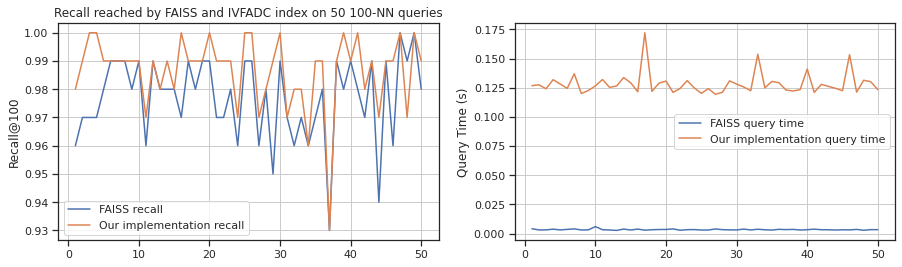

time: 523 ms (started: 2022-04-14 21:16:10 +00:00)


In [ ]:
sns.set_theme(style='ticks')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

x_q = np.array(range(1,n_queries+1))

# recall vs search_time
sns.lineplot(data=results, x=x_q, y='faiss_recall', ax=ax1)
sns.lineplot(data=results, x=x_q, y='recall', ax=ax1)
ax1.title.set_text(f"Recall reached by FAISS and IVFADC index on {n_queries} {k}-NN queries")
ax1.set_ylabel('Recall@100')
ax1.legend(["FAISS recall", "Our implementation recall"])
ax1.grid()

sns.lineplot(data=results, x=x_q, y='search_time_faiss', ax=ax2)
sns.lineplot(data=results, x=x_q, y='search_time_ivfadc', ax=ax2)
ax2.set_ylabel('Query Time (s)')
ax2.legend(["FAISS query time", "Our implementation query time"])
ax2.grid()

In [ ]:
results_mean = results.mean()

print(f"Mean query time FAISS: {results_mean['search_time_faiss']:.4f}")
print(f"Mean query time Our implementation: {results_mean['search_time_ivfadc']:.4f}")
print(f"Mean recall FAISS: {results_mean['faiss_recall']:.2f}")
print(f"Mean recall Our implementation: {results_mean['recall']:.2f}")

Mean query time FAISS: 0.0034
Mean query time Our implementation: 0.1283
Mean recall FAISS: 0.98
Mean recall Our implementation: 0.99
time: 5.47 ms (started: 2022-04-14 21:16:17 +00:00)


###Experiment 6 - Our Implementation Vs FAISS + Distractors

In [ ]:
#path_features_distractors = "/content/drive/Shareddrives/MIRCV Project/others/features/features_512_distractors.npy"
#path_features_images = "/content/drive/Shareddrives/MIRCV Project/others/features/features_512.npy"

#features_images = np.load(path_features_images)
#features_distractors = np.load(path_features_distractors)

#features_512_distractors = np.concatenate((features_images, features_distractors))

path = '/content/drive/Shareddrives/MIRCV Project/Performance Evaluation/features_train_dis_512_FT.pkl'
features_512_distractors = np.load(path, allow_pickle=True)
features_512_distractors.shape

(45580, 512)

time: 170 ms (started: 2022-04-14 21:16:39 +00:00)


In [ ]:
#normalize 
features_512_distractors = normalize(features_512_distractors)

time: 89.2 ms (started: 2022-04-14 21:16:40 +00:00)


In [ ]:
n, d = features_512_distractors.shape
n_queries = 50

# select random query from the dataset
query_index = np.random.choice(n, n_queries, replace=False)
query = features_512_distractors[query_index]
current_features = np.delete(features_512_distractors, query_index, axis=0)
n, d = current_features.shape

current_features.shape, query.shape

((45530, 512), (50, 512))

time: 35.3 ms (started: 2022-04-14 21:16:40 +00:00)


In [ ]:
nlist = 45
n_subvec = 256
n_bits = 8

train_subset_index = np.random.choice(current_features.shape[0], 5_000, replace=False)


coarse_quantizer = faiss.IndexFlatL2(d)
index_faiss = faiss.IndexIVFPQ(coarse_quantizer, d, nlist, n_subvec, n_bits)

start = time.time()
index_faiss.train(current_features[train_subset_index])
index_faiss.add(current_features)
train_time_faiss = time.time() - start

# build the index
inverted_list = KmeansCoarseQuantizer(d, nlist)
index = IVFADC(inverted_list, d, n_subvec, n_bits)
index.train(current_features, train_subset_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


time: 2min 50s (started: 2022-04-14 21:16:40 +00:00)


In [ ]:
print(f"Training time FAISS: {train_time_faiss:.2f}")
print(f"Training time Our implementation: {index.get_train_time():.2f}")

Training time FAISS: 38.65
Training time Our implementation: 131.76
time: 3.75 ms (started: 2022-04-14 21:19:30 +00:00)


In [ ]:
n_probe = 10
k = 100

index_faiss.nprobe = n_probe

results = []
for i, q in enumerate(query):
  q = q.reshape(1,-1)

  true_neighbors, true_dist, _ = compute_true_neighbors(q, current_features, k)

  start = time.time()
  D_faiss, I_faiss = index_faiss.search(q, k)
  search_time_faiss = time.time() - start

  I_ivfadc, D_ivfadc, search_time_ivfadc = index.search(q, k, n_probe, "sqeuclidean")

  result = {
      "faiss_recall": index.compute_recall(true_neighbors, I_faiss),
      "recall": index.compute_recall(true_neighbors, I_ivfadc),
      "search_time_faiss": search_time_faiss,
      "search_time_ivfadc": search_time_ivfadc
  }

  results.append(result)

results = pd.DataFrame(results)
results

,faiss_recall,recall,search_time_faiss,search_time_ivfadc
0,0.96,0.99,0.005446,0.144162
1,0.97,0.97,0.006332,0.162847
2,0.98,0.99,0.005504,0.146629
3,0.93,0.91,0.006855,0.151477
4,0.95,0.94,0.005867,0.165980
5,0.98,0.96,0.005963,0.161600
6,0.98,0.97,0.006139,0.158919
7,0.83,0.95,0.005676,0.150727
8,0.95,0.95,0.005889,0.170551
9,0.95,0.97,0.004732,0.145569


time: 10.9 s (started: 2022-04-14 21:19:30 +00:00)


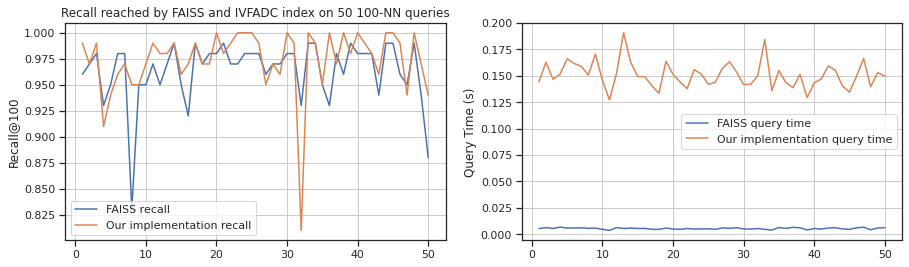

time: 533 ms (started: 2022-04-14 21:19:41 +00:00)


In [ ]:
sns.set_theme(style='ticks')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

x_q = np.array(range(1,n_queries+1))

# recall vs search_time
sns.lineplot(data=results, x=x_q, y='faiss_recall', ax=ax1)
sns.lineplot(data=results, x=x_q, y='recall', ax=ax1)
ax1.title.set_text(f"Recall reached by FAISS and IVFADC index on {n_queries} {k}-NN queries")
ax1.set_ylabel('Recall@100')
ax1.legend(["FAISS recall", "Our implementation recall"])
ax1.grid()

sns.lineplot(data=results, x=x_q, y='search_time_faiss', ax=ax2)
sns.lineplot(data=results, x=x_q, y='search_time_ivfadc', ax=ax2)
ax2.set_ylabel('Query Time (s)')
ax2.legend(["FAISS query time", "Our implementation query time"])
ax2.grid()

In [ ]:
results_mean = results.mean()

print(f"Mean query time FAISS: {results_mean['search_time_faiss']:.4f}")
print(f"Mean query time Our implementation: {results_mean['search_time_ivfadc']:.2f}")
print(f"Mean recall FAISS: {results_mean['faiss_recall']:.2f}")
print(f"Mean recall Our implementation: {results_mean['recall']:.2f}")

Mean query time FAISS: 0.0055
Mean query time Our implementation: 0.15
Mean recall FAISS: 0.96
Mean recall Our implementation: 0.97
time: 10.5 ms (started: 2022-04-14 21:24:54 +00:00)


#PROVA_non toccare

In [ ]:
nlist = 20
nprobe = 5
n_subvec = 128
n_bits = 8
k = 100

inverted_list = KmeansCoarseQuantizer(d, nlist)
index = IVFADC(inverted_list, d, n_subvec, n_bits)
index.train(features_512, 5_000)

/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


time: 46 s (started: 2022-04-13 17:09:39 +00:00)


In [ ]:
I, D, search_time = index.search(query, k, nprobe, 'dot')

Output streaming troncato alle ultime 5000 righe.
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4

In [ ]:
recall = index.compute_recall(true_neighbors, I)
recall 

0.4364

time: 11.6 ms (started: 2022-04-13 17:06:23 +00:00)


In [ ]:
index.save_index("index.pkl")

time: 74.4 ms (started: 2022-04-13 15:39:47 +00:00)


In [ ]:
with open("index.pkl", "rb") as fp:  
    index = pickle.load(fp)

time: 46.7 ms (started: 2022-04-13 15:30:12 +00:00)
